# Statistical Research

### 1) Download libraries and modules

In [18]:
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr, kendalltau
from pathlib import Path
from typing import List, Optional
from fitter import Fitter
import seaborn as sns

In [19]:
def project_root(start: Path | None = None) -> Path:
    p = (start or Path.cwd()).resolve()
    for candidate in [p, *p.parents]:
        if (candidate / "pyproject.toml").exists():
            return candidate
    return p

### 2) Download train data 

We first make data usable by downloading it into a Polars dataframeº

In [20]:
root_path = project_root()
# 160,000 rows error fix 
train_data = pd.read_csv(root_path / "data" / "train.csv")
train_data_new = pd.read_csv(root_path / "data" / "train_new.csv")

merged_data = pd.concat([train_data, train_data_new], axis=0)
columns = [col for col in merged_data.columns if col not in ['Y1', 'Y2']] + ['Y1', 'Y2']
merged_data = merged_data[columns]
merged_data = merged_data.set_index("time")
merged_data.to_csv(root_path / "data" / "full_train_data.csv")
train_data_new = pd.read_csv(root_path / "data" / "full_train_data.csv")
train_data = pl.DataFrame(merged_data)
print("TRAIN DATA\n")
print(train_data.head())

print("TEST DATA\n")
test_data = pl.read_csv(root_path / "data" / "test.csv")
print(test_data.head())


TRAIN DATA

shape: (5, 18)
┌───────────┬───────────┬───────────┬───────────┬───┬──────┬──────┬───────────┬───────────┐
│ A         ┆ B         ┆ C         ┆ D         ┆ … ┆ O    ┆ P    ┆ Y1        ┆ Y2        │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---  ┆ ---  ┆ ---       ┆ ---       │
│ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64  ┆ f64  ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪══════╪══════╪═══════════╪═══════════╡
│ 0.207366  ┆ -0.159951 ┆ -0.634176 ┆ -0.580962 ┆ … ┆ null ┆ null ┆ -0.935902 ┆ -0.310081 │
│ 0.188828  ┆ -0.265508 ┆ 0.042143  ┆ -0.550442 ┆ … ┆ null ┆ null ┆ -0.089707 ┆ -0.305374 │
│ -0.144261 ┆ -0.577142 ┆ -0.214634 ┆ -0.747391 ┆ … ┆ null ┆ null ┆ -0.077855 ┆ -0.631485 │
│ 0.208982  ┆ -0.310449 ┆ 0.513708  ┆ -0.562868 ┆ … ┆ null ┆ null ┆ 0.941271  ┆ -0.535212 │
│ 0.09332   ┆ -0.358156 ┆ 0.173188  ┆ -0.687296 ┆ … ┆ null ┆ null ┆ -0.039582 ┆ -0.490561 │
└───────────┴───────────┴───────────┴───────────┴───┴

### 3) Visualize Relationship betweeen Targets and Explanatory Variables

Plot features dependency with the variables into scatter plot grids

In [21]:
def plot_grid_vs_target(target: np.ndarray, label: str, num_rows: int, num_cols: int, columns_to_plot: List[str], colour: str):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    aces = np.atleast_1d(axes).ravel()
    corr_dict = {}
    y = np.asarray(target, dtype=float)

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]
        x = np.asarray(train_data[col], dtype=float)

        m = np.isfinite(x) & np.isfinite(y)
        corr = np.corrcoef(x[m], y[m])[0, 1] if m.any() else np.nan

        corr_dict[col] = corr

        ax.scatter(x[m], y[m], alpha=0.5, color=colour)
        ax.set_title(f"{col} vs {label}\ncorr={corr:.4f}" if np.isfinite(corr) else f"{col} vs {label}\ncorr=nan")
        ax.set_xlabel(col)
        ax.set_ylabel(label)

        for j in range(len(columns_to_plot), len(axes)):
            fig.delaxes(axes[j])
        
        fig.suptitle(f"Features vs {label}", y=0.995, fontsize=16)
        fig.tight_layout()
        plt.show()
        return corr_dict
    

def superpose_grids(targets: List[np.ndarray], labels: List[str], num_rows: int, num_cols: int, columns_to_plot: List[str], colours: List[str]):

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5 * num_rows))
    axes = np.atleast_1d(axes).ravel()

    for i, col in enumerate(columns_to_plot):
        ax = axes[i]
        x = np.asarray(train_data[col].to_numpy(), dtype=float).ravel()
        corrs = [] 

        for num, target in enumerate(targets):
            y = np.asarray(target, dtype=float).ravel()
            m = np.isfinite(x) & np.isfinite(y)
            if m.sum() >= 2 and np.std(x[m]) > 0 and np.std(y[m]) > 0:
                c = np.corrcoef(x[m], y[m])[0, 1]
            else:
                c = np.nan

            corrs.append(c)
            ax.scatter(x[m], y[m], alpha=0.5, label=labels[num], color=colours[num])
    

        corr_txt = "  |  ".join(
            f"corr({lbl})={c:.4f}" if np.isfinite(c) else f"corr({lbl})=nan"
            for lbl, c in zip(labels, corrs)
        )
        ax.set_title(f"{col} vs targets\n{corr_txt}")
        ax.set_xlabel(col)
        ax.set_ylabel("target")
        ax.legend(loc="best")

    for j in range(len(columns_to_plot), len(axes)):
        fig.delaxes(axes[j])

    fig.tight_layout()
    plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'scatter'

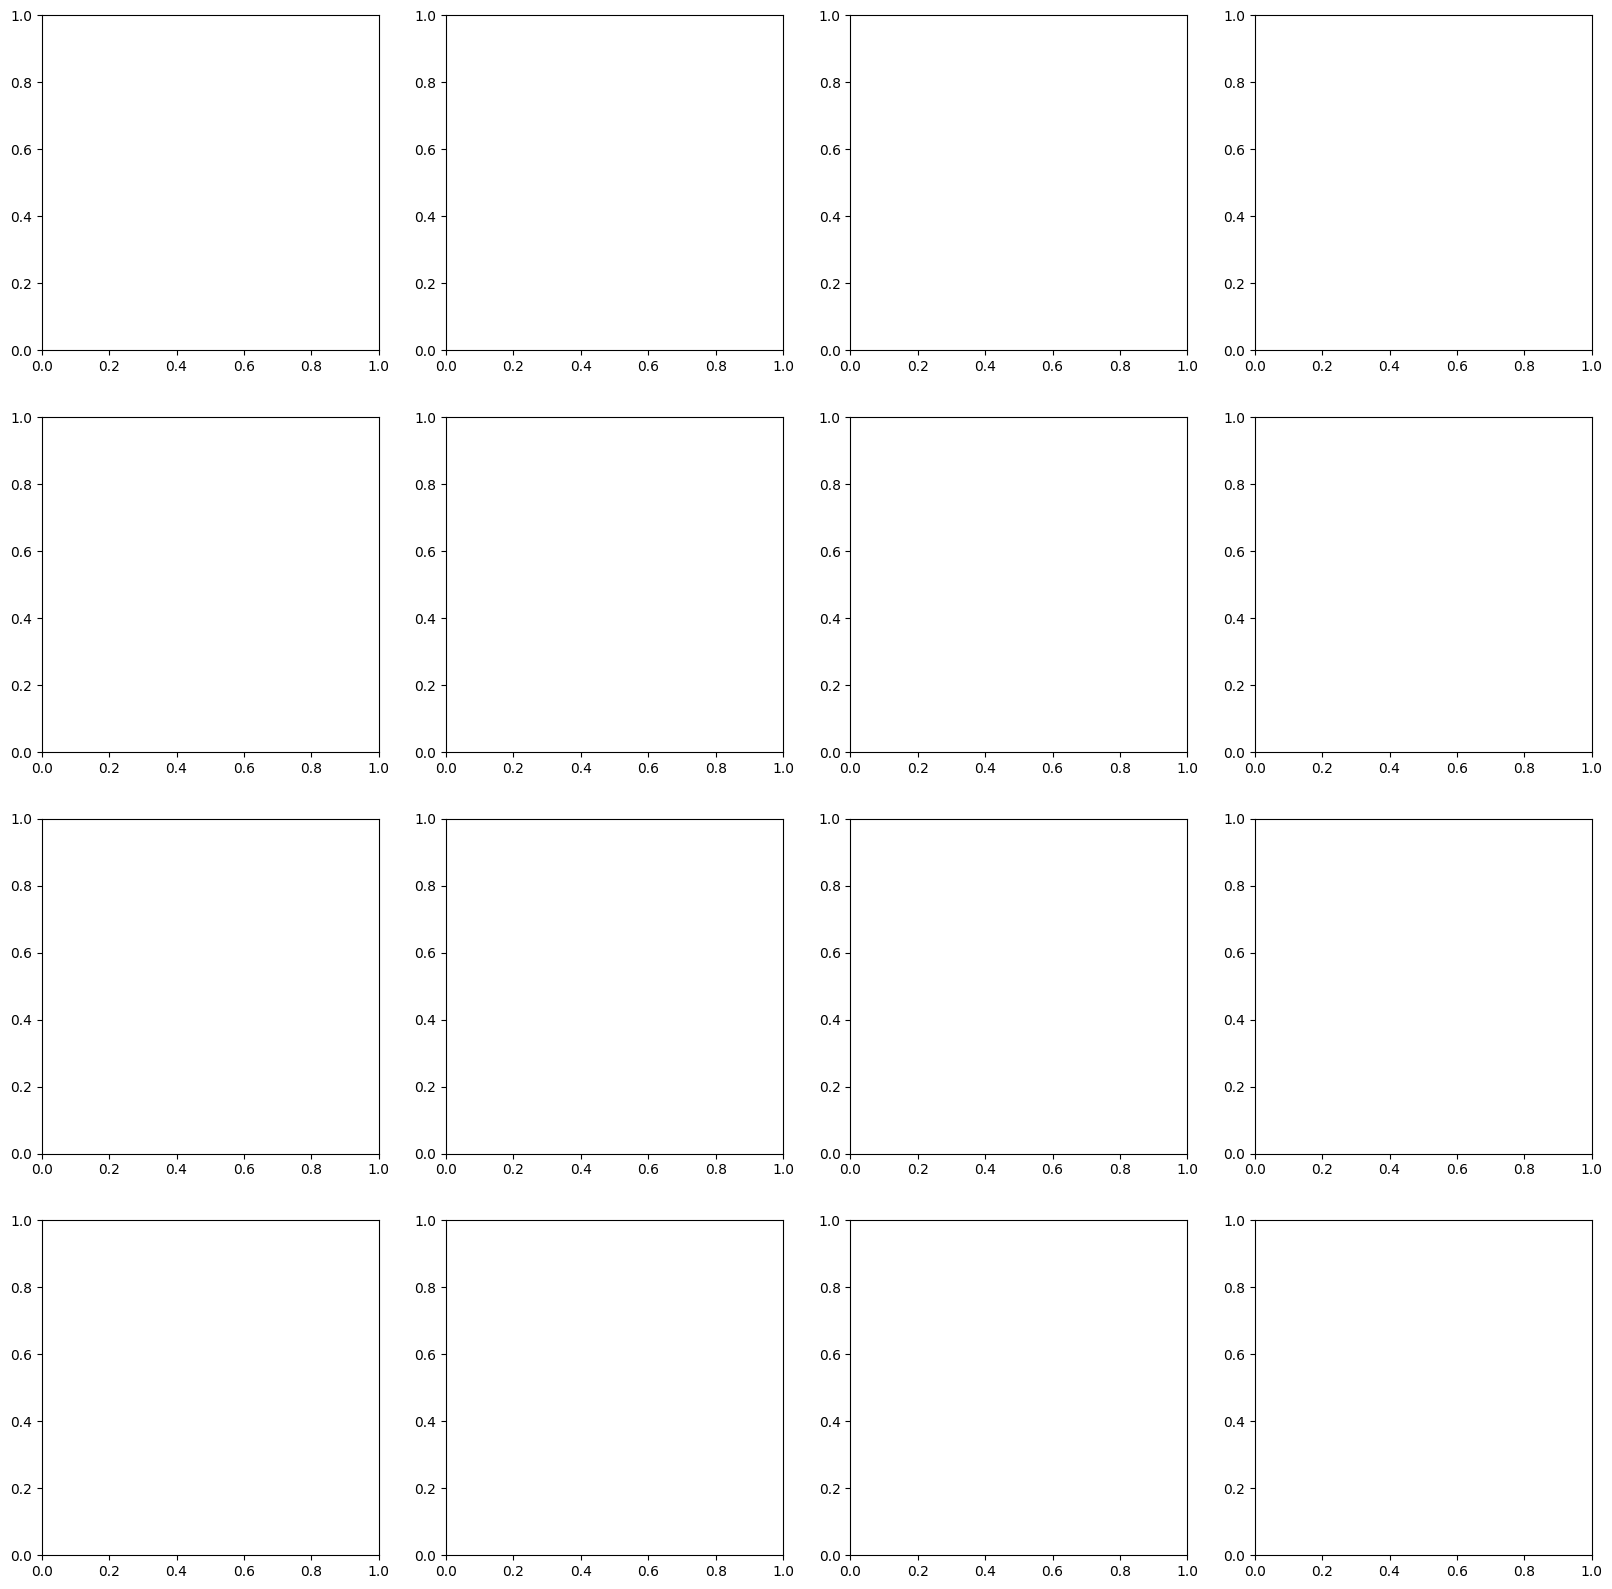

In [22]:
columns_to_plot = [c for c in columns if c not in ['time', 'Y1', 'Y2']]

num_cols = 4
num_rows= -(-len(columns_to_plot) // num_cols)
list_targets = [train_data["Y1"].to_numpy(),train_data["Y2"].to_numpy()]

correlation_dict_Y1 = plot_grid_vs_target(list_targets[0], "Y1", num_rows, num_cols, columns_to_plot, "blue")
print("\n")
correlation_dict_Y2 = plot_grid_vs_target(list_targets[1], "Y2", num_rows, num_cols, columns_to_plot, "red")
print("\n")
superpose_grids(list_targets, ["Y1","Y2"], num_rows, num_cols, columns_to_plot, ["blue","red"])